In [1]:
%pylab inline
from collections import Counter, defaultdict
import pandas as pd
import glob
import os
import itertools
from matplotlib.legend import Legend
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_context('poster')#, font_scale=2)
sns.set_style('white')
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from ee546_utils import *
#MARKERS = list(Line2D.filled_markers)
MARKERS = ['o',  'x', '^', '*', 'H', '<', 's',  '>', '8', 'p', 'h',  'D', 'd', 'P']
def _get_PCA_colors_markers(target_names):
    colors = {}
    indexes = defaultdict(list)
    all_species = {}
    row_colors = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors.keys():
            colors[tissue] = sns.color_palette('tab10')[len(colors)]
        row_colors.append(colors[tissue])
        indexes[tissue].append(index)
        all_species[index] = species
        
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        indexes[tissue].append(index)
    return indexes, markers_list, colors_list, colors_dict, markers_dict

def do_PCA(X, target_names, ax=None):
    pca = PCA(n_components=min(X.shape))
    X_r = pca.fit(X).transform(X)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()
    colors = sns.color_palette('Paired')
    lw = 2
    indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)


    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(X_r[value, 0], 
                       X_r[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
        
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        annotations.append(tissue)
        scatter_points.append(p)
        
   
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(species)
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0,
                 #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
                 )# frameon=False)
    ax.add_artist(leg)
    
    #ax.set_title('PCA')
    ax.set_xlabel('PC1 ({:.2f} %)'.format(pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC2 ({:.2f} %)'.format(pca.explained_variance_ratio_[1]*100))
    #fig.tight_layout()
    
    return X_r, fig

def _get_CCA_colors_markers(target_names):
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        if index < X.shape[0]:
            indexes_x[tissue].append(index)
        else:
            indexes_y[tissue].append(index-X.shape[0])
    return indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict
    
def do_CCA(X, Y, target_names, ax=None):
    
    
    cca = CCA(n_components=2)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8.5))
    else:
        fig = ax.get_figure()    #assert 
    indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict = _get_CCA_colors_markers(target_names)
    for tissue, values in indexes_x.items():
        for value in values:
            ax.scatter(X_c[value, 0], 
                       X_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
    for tissue, values in indexes_y.items():
        for value in values:
            ax.scatter(Y_c[value, 0], 
                       Y_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value+X_c.shape[0]],
                       lw=5)
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        annotations.append(tissue)
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Tissue',
    #             bbox_to_anchor=(1.04,1), loc="upper left",)
    
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(species)
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0)
    ax.add_artist(leg)
    #ax.set_title('CCA')
    ax.set_xlabel('CC1')
    ax.set_ylabel('CC2')
    #fig.tight_layout()
    #fig.tight_layout()
    return fig

Populating the interactive namespace from numpy and matplotlib


# 01. Read Data

In [2]:
ortho_pairwise = {}
for f in glob.glob('../ortholog_tsv/*.tsv'):
    if 'ortholog_one2one' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    print(f)
    ortho_pairwise[f.split('/')[-1].replace('.tsv', '')] = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')

../ortholog_tsv/mmusculus_btaurus.tsv
../ortholog_tsv/mmusculus_ggallus.tsv
../ortholog_tsv/mmusculus_ggorilla.tsv
../ortholog_tsv/mmusculus_hsapiens.tsv
../ortholog_tsv/mmusculus_mdomestica.tsv
../ortholog_tsv/mmusculus_mmulatta.tsv
../ortholog_tsv/mmusculus_oanatinus.tsv
../ortholog_tsv/mmusculus_pabelii.tsv
../ortholog_tsv/mmusculus_ppaniscus.tsv
../ortholog_tsv/mmusculus_ptroglodytes.tsv
../ortholog_tsv/mmusculus_rnorvegicus.tsv


In [3]:
ONE2ONE_orthologs = pd.read_table('../ortholog_tsv/ortholog_one2one.tsv')

# 02. Read kallisto tables SRP007412

In [4]:
kallisto_counts = {}
srp_species =  defaultdict(list)
for f in glob.glob('../cross-species-data/SRP007412-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    species = species[0] + species.split('_')[-1]
    kallisto_counts['{}_{}'.format(srp, species)] = pd.read_table(f)
    srp_species[srp].append(species)

In [5]:
srp = 'SRP007412'
pairwise_kallisto_counts = {}
pairwise_kallisto_counts_normalized = {}
pairwise_kallisto_counts_normalized_individual = defaultdict(dict)
for species1, species2 in itertools.combinations(srp_species[srp], 2):
    # load counts
    counts1 = kallisto_counts['{}_{}'.format(srp, species1)]
    counts2 = kallisto_counts['{}_{}'.format(srp, species2)]
    
    if species1 ==  'mmusculus':
        species1, species2 = species2, species1
        counts1, counts2 = counts2, counts1
        #cols_to_use = counts1.columns.tolist()
        # Only use these columns in the second dataframe
        #counts2 = counts2.loc[:, cols_to_use]
    if species2 ==  'mmusculus':
        cols_to_use = counts2.columns.tolist()
        # Only use these columns in the second dataframe
        counts1 = counts1.loc[:, cols_to_use]
    intersecting_columns = set(counts1.columns.tolist()).intersection(set(counts2.columns.tolist()))
    intersecting_columns = list(sorted(intersecting_columns))
    
    counts1 = counts1.loc[:, intersecting_columns]
    counts2 = counts2.loc[:, intersecting_columns]
                                                                    
    if species2 != 'mmusculus':
        ortho1 = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho1 = ortho1.loc[ortho1['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho1 = ortho1.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
    
        ortho2 = ortho_pairwise['mmusculus_{}'.format(species2)]
        ortho2 = ortho2.loc[ortho2['{}_homolog_orthology_type'.format(species2)]=='ortholog_one2one']
        ortho2 = ortho2.drop(columns=['{}_homolog_orthology_type'.format(species2)]) 
        
        ortho_12 = ortho1.join(ortho2, how='outer').dropna().reset_index(drop=True)\
                    .set_index('{}_homolog_ensembl_gene'.format(species1))
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species2)
        species1_ortho_genes  = ortho_12.index
        species2_ortho_genes  = ortho_12['{}_homolog_ensembl_gene'.format(species2)]
        
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts1_trimmed.index
        reduced_set = ortho_12.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts2_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set.index]
        counts2_trimmed = counts2_trimmed.loc[reduced_set[species2_lookup_col]]
        del ortho_12
        del reduced_set
        del ortho1
        del ortho2
    else:
        
        ortho = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho = ortho.loc[ortho['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho = ortho.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species1)

        species1_ortho_genes  = ortho['{}_homolog_ensembl_gene'.format(species1)]
        species2_ortho_genes  = ortho.index.tolist()
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts2_trimmed.index
        reduced_set = ortho.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts1_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set[species2_lookup_col]]
        counts2_trimmed = counts2_trimmed.loc[reduced_set.index]                        
        del ortho
    if len(counts1.columns)!= len(counts2.columns):
        print('Skipping {}, {}'.format(species1, species2))
        continue
    assert (counts1.columns == counts2.columns).all()
    
    counts1_trimmed.columns =  ['{}_{}'.format(species1, x) for x in counts1_trimmed.columns]
    counts2_trimmed.columns =  ['{}_{}'.format(species2, x) for x in counts2_trimmed.columns]
    
    del counts1
    del counts2
    counts2_trimmed.index = counts1_trimmed.index.tolist()
    counts_concat = pd.concat([counts1_trimmed.T, counts2_trimmed.T], ignore_index=False)
    pairwise_kallisto_counts['{}_{}'.format(species1, species2)] = counts_concat
    
    counts_concat_centered = counts_concat.sub(counts_concat.mean(axis=1), axis=0)
    counts_concat_centered = counts_concat_centered.div(counts_concat_centered.std(axis=1), axis=0)
    
    pairwise_kallisto_counts_normalized['{}_{}'.format(species1, species2)] = counts_concat_centered
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species1] = counts_concat_centered.iloc[:len(counts1_trimmed.T.index),]
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species2] = counts_concat_centered.iloc[len(counts1_trimmed.T.index):,]

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:42: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:43: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in th

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ValueError: Found array with 0 feature(s) (shape=(34, 0)) while a minimum of 1 is required.

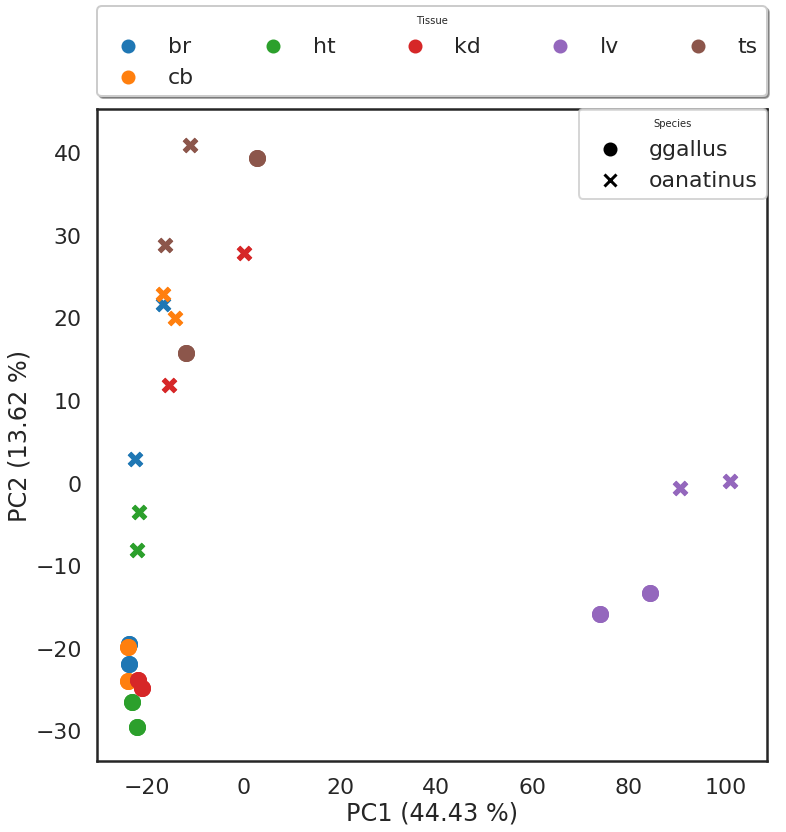

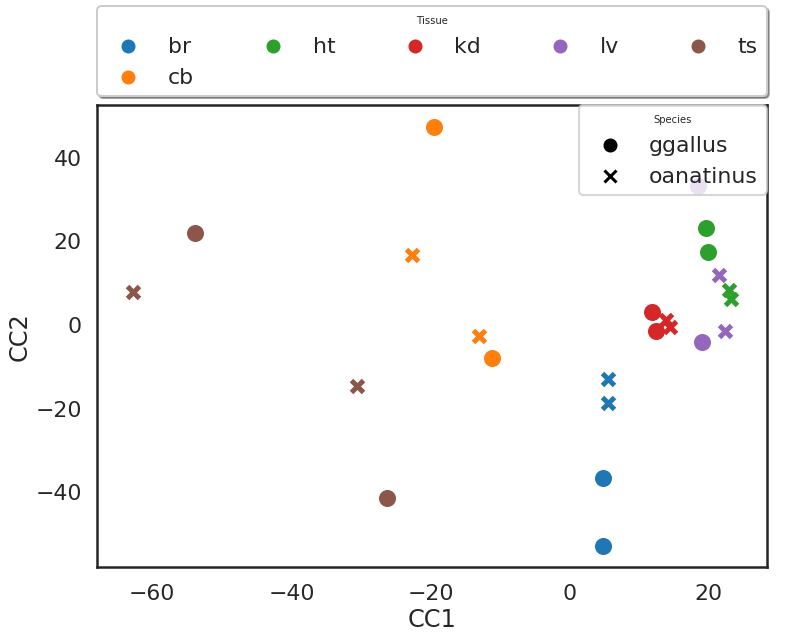

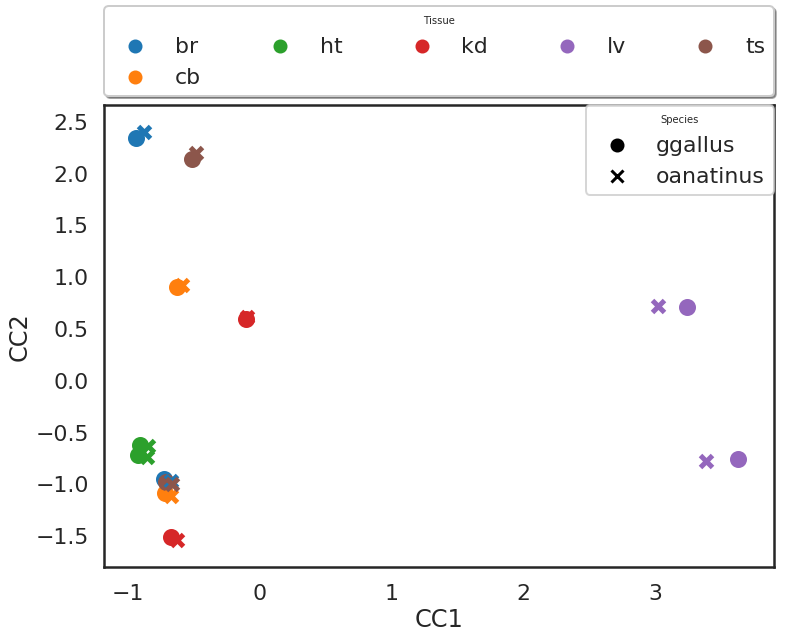

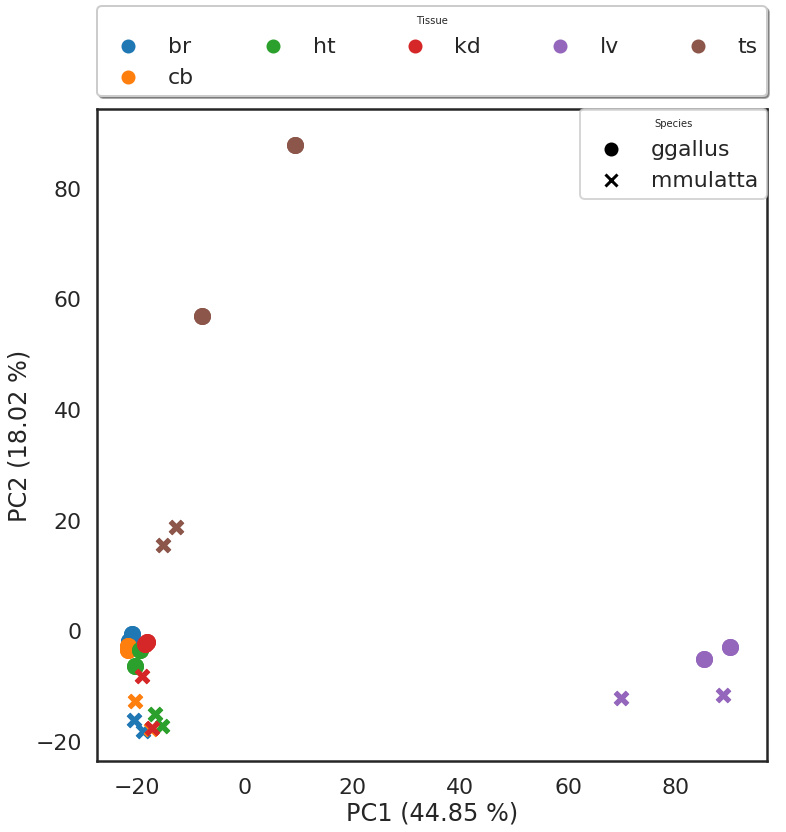

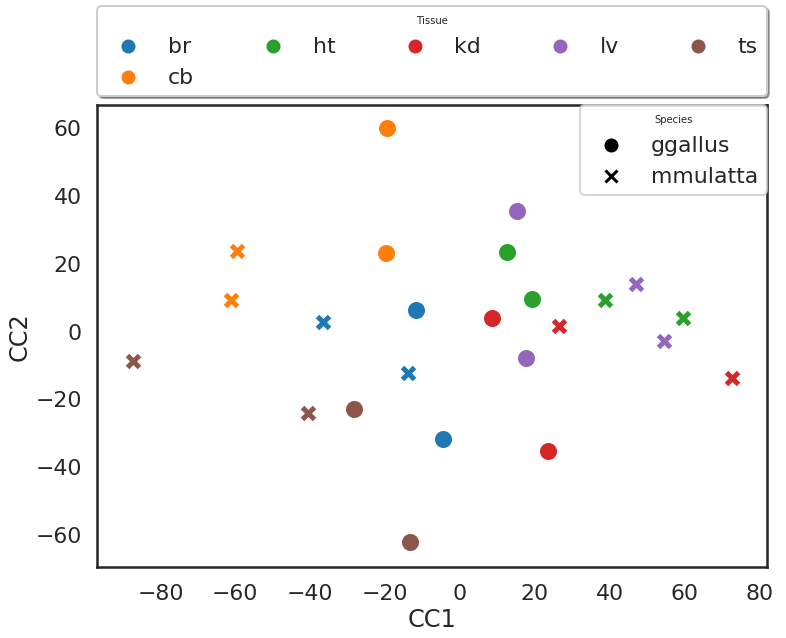

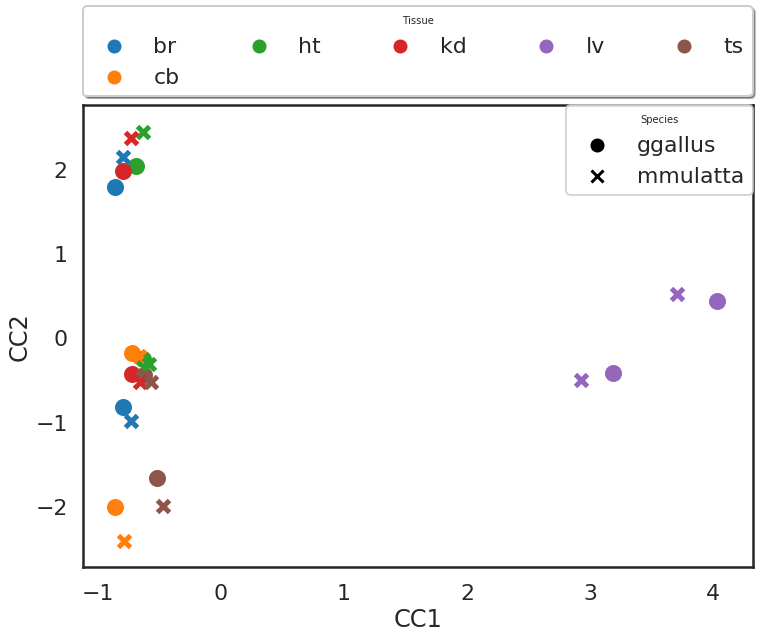

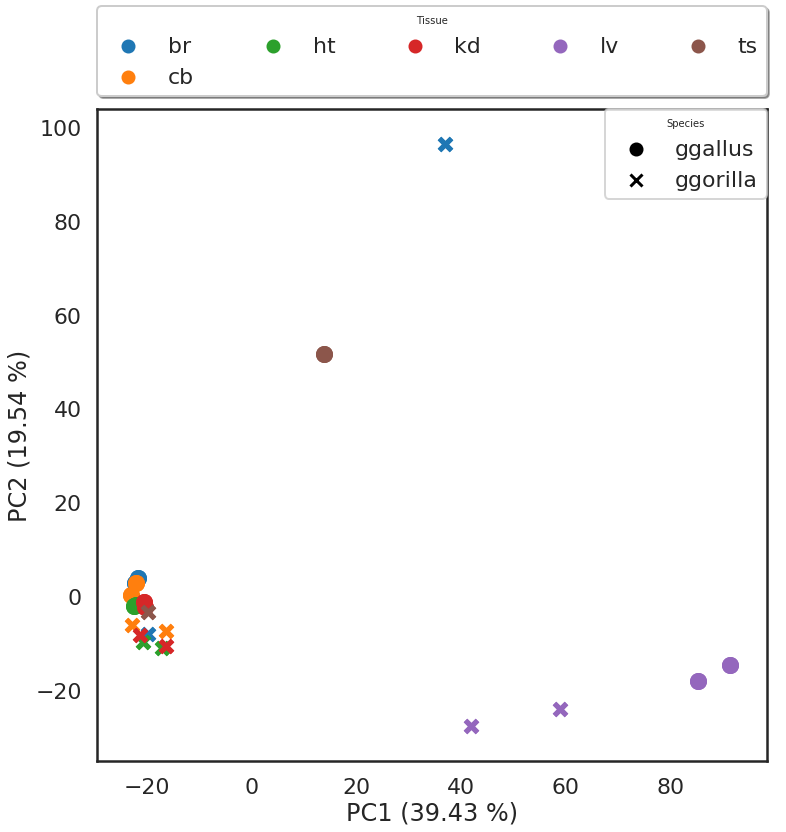

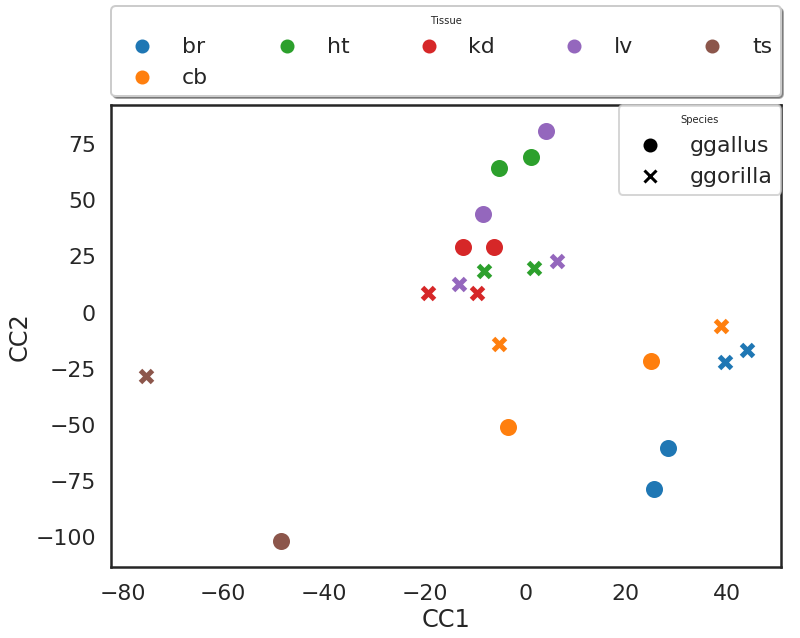

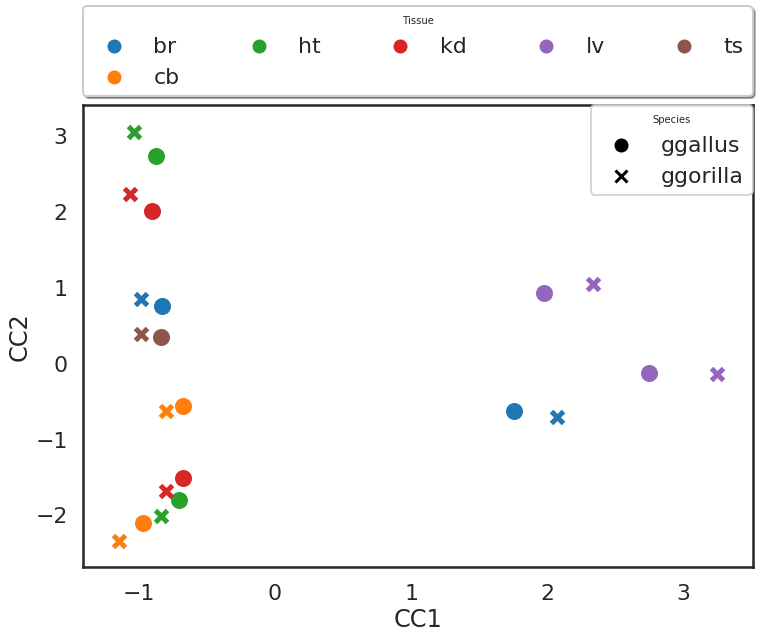

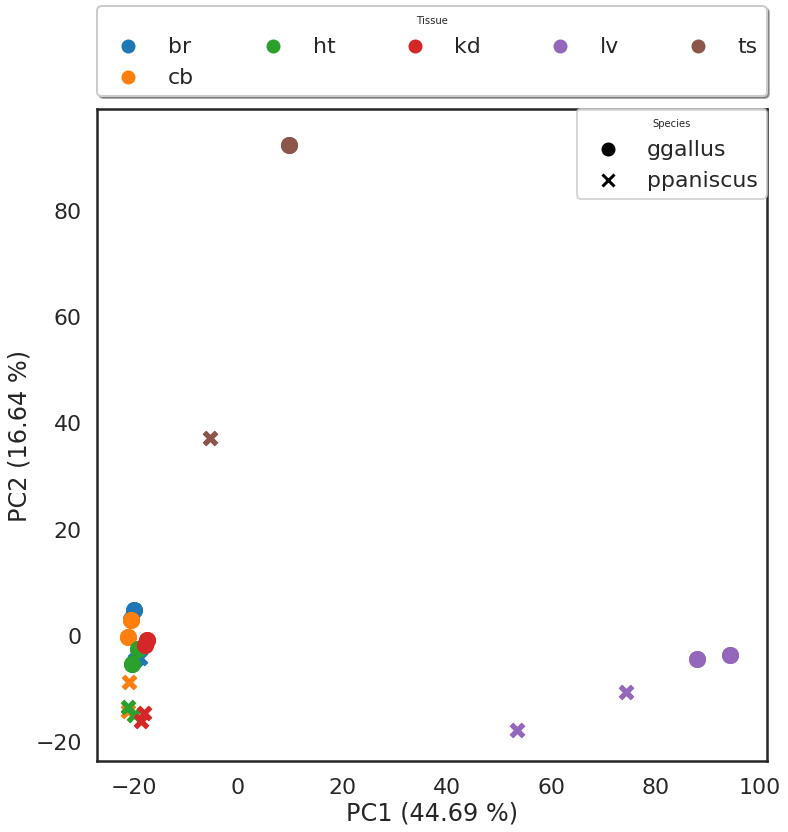

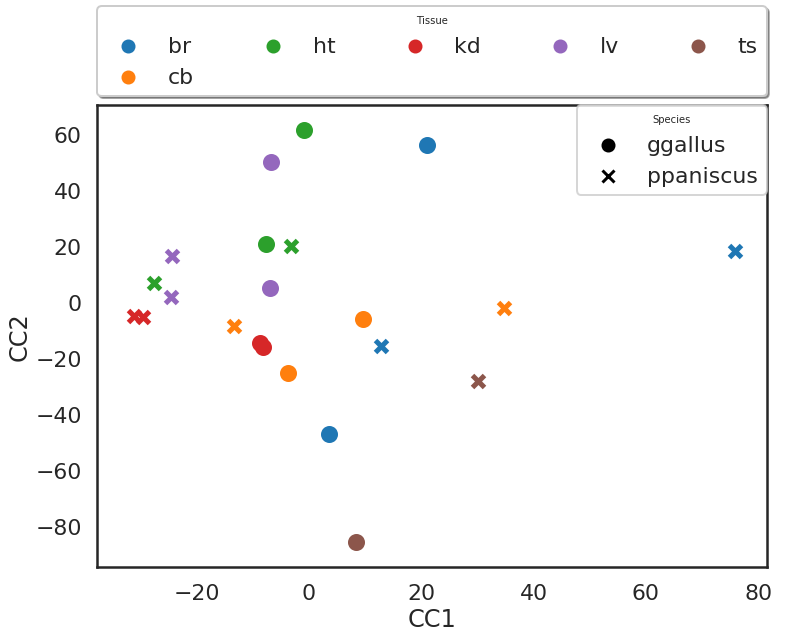

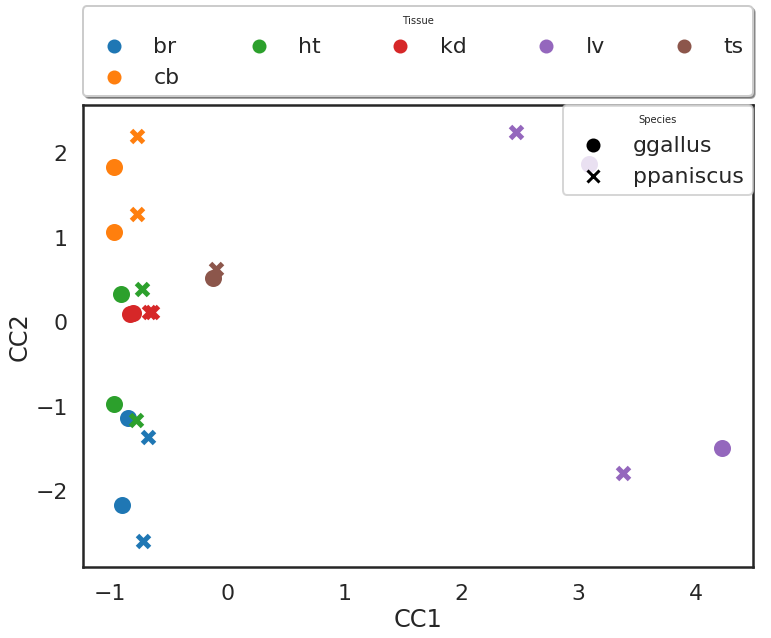

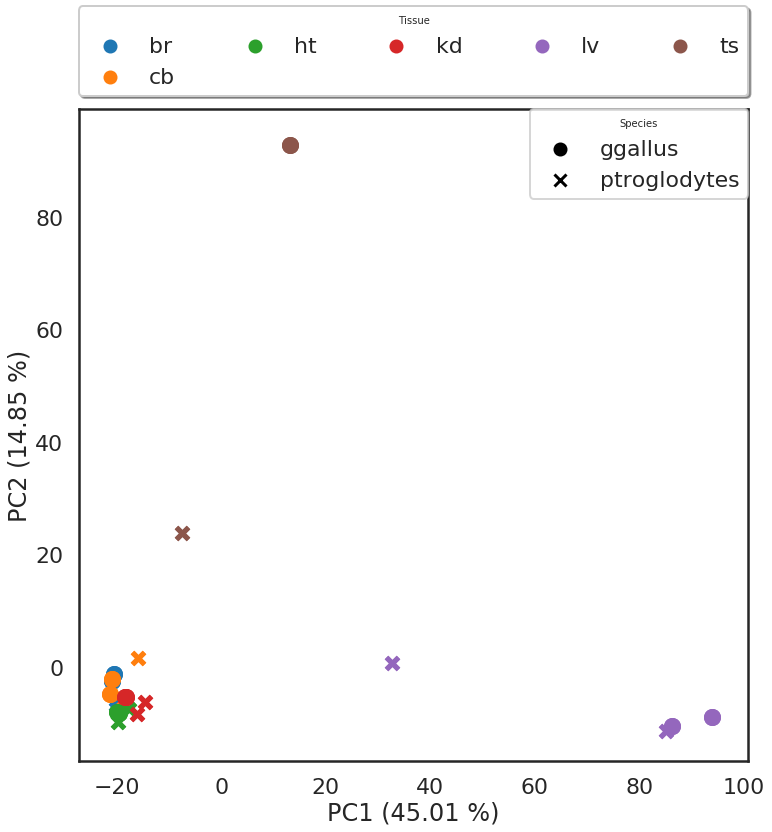

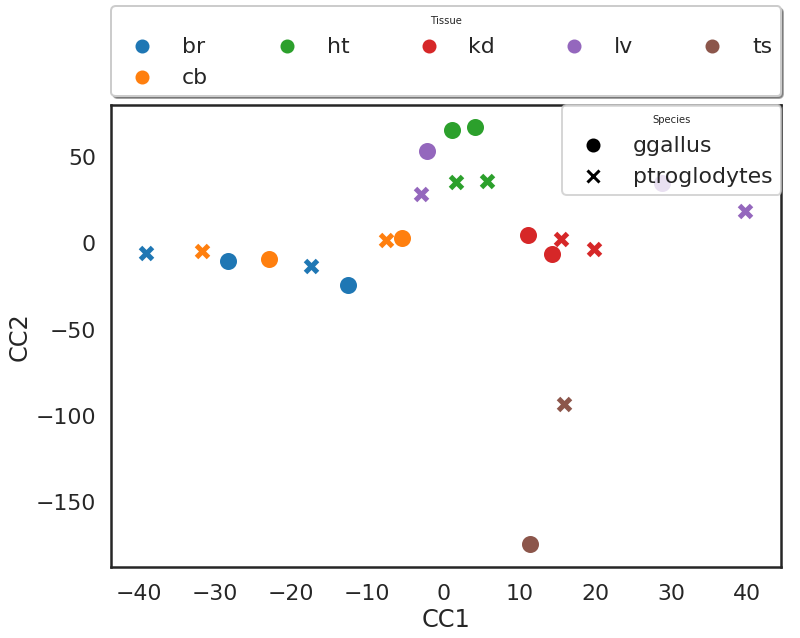

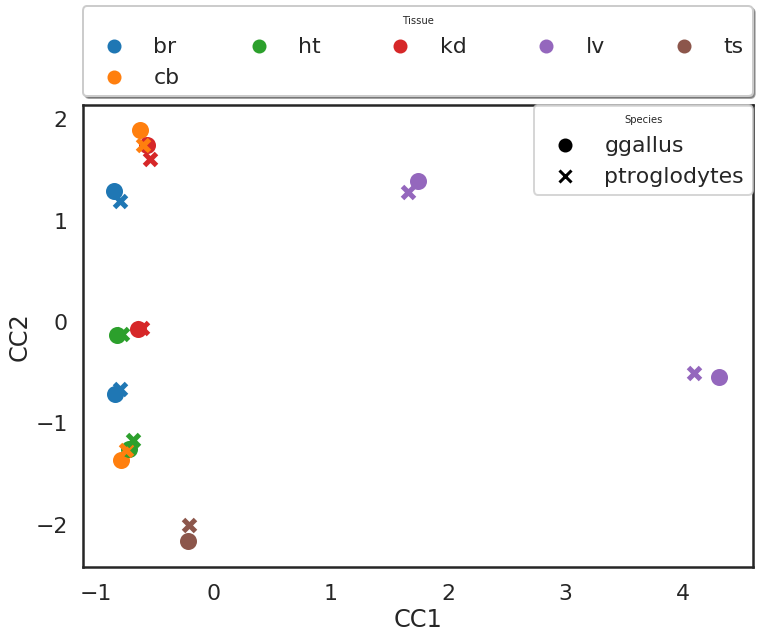

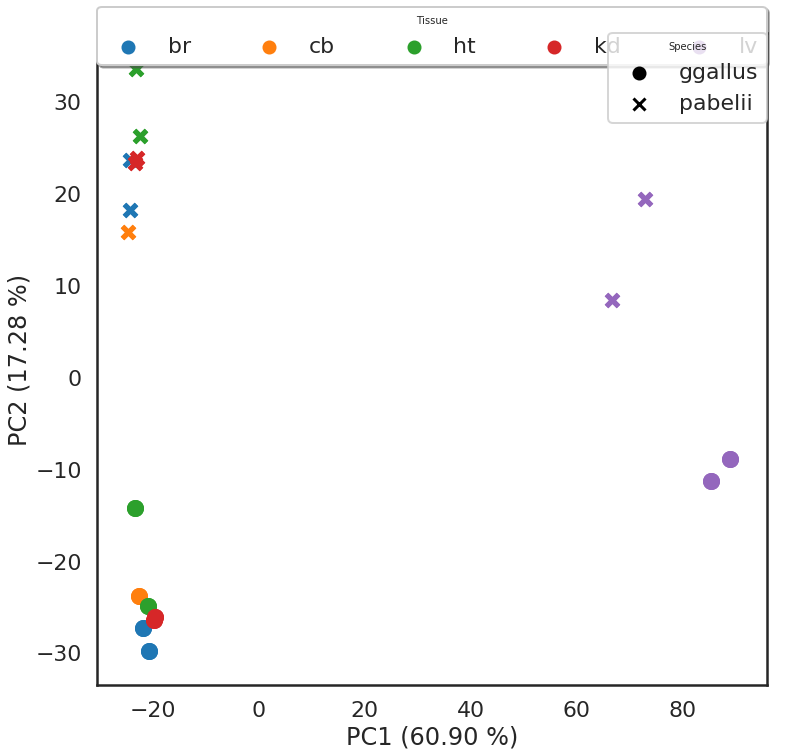

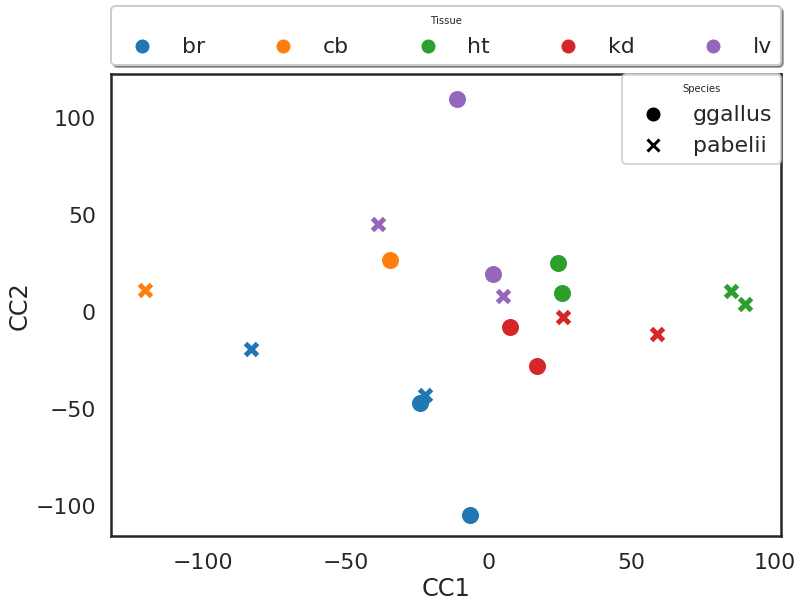

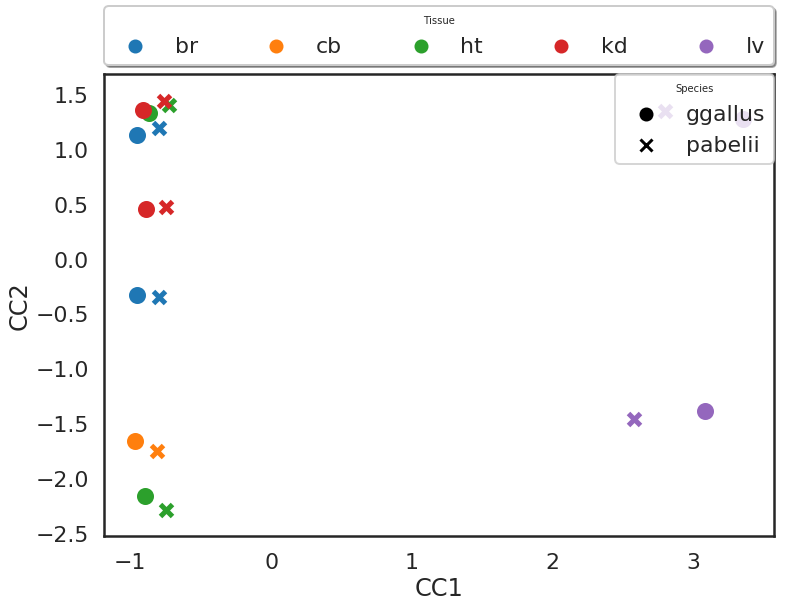

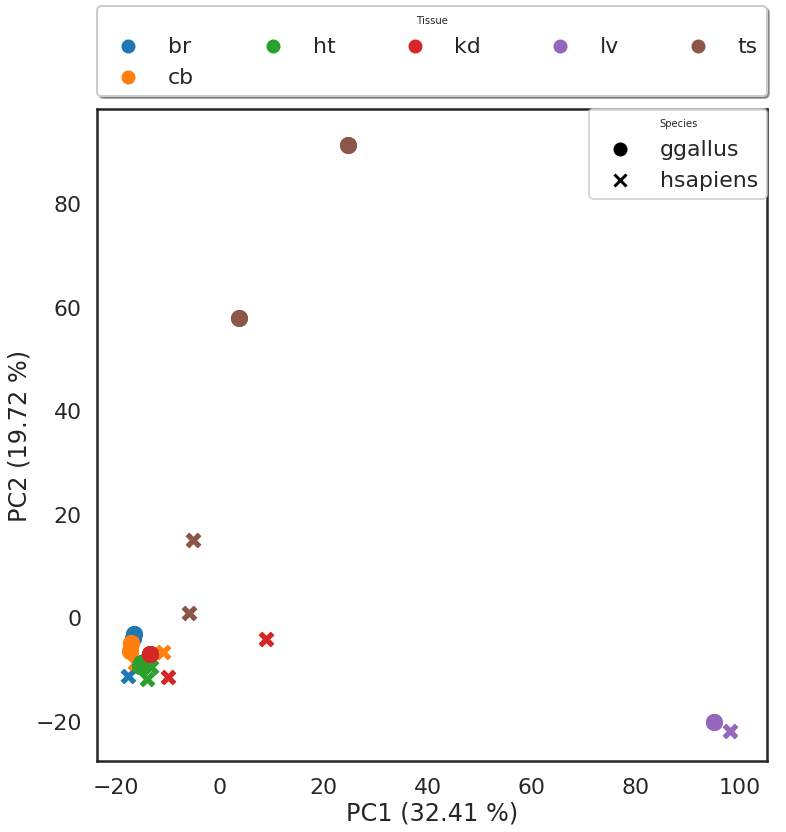

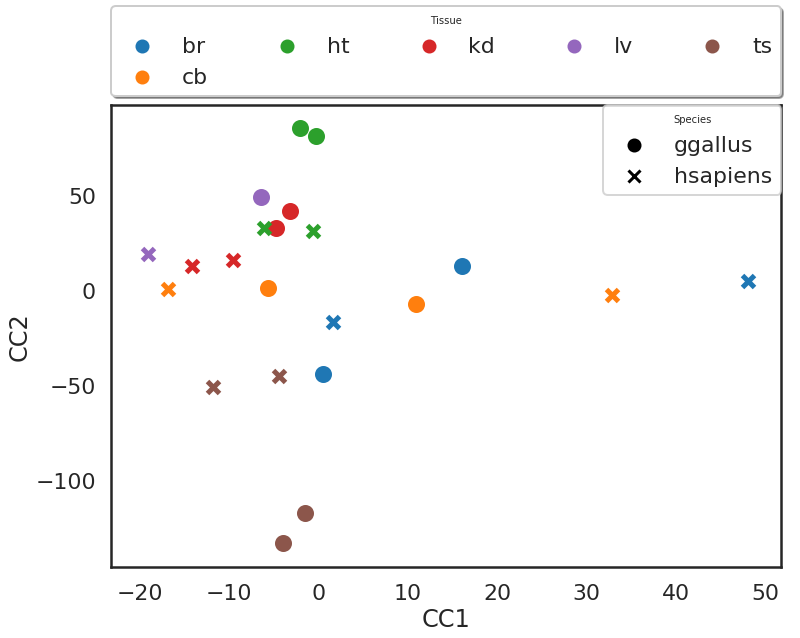

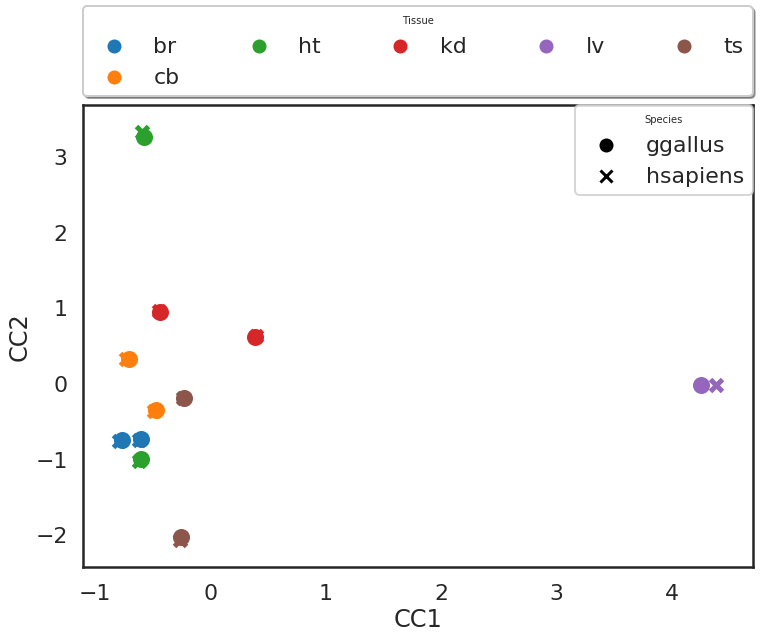

In [6]:
for species_pair, counts in pairwise_kallisto_counts_normalized.items():
    X = counts.values
    target_names = counts.index
    X_r, fig = do_PCA(X, target_names)
    species1, species2 = species_pair.split('_')
    fig.savefig('../{}_plots/pca_normalized_{}_{}.pdf'.format(srp, species, species2), 
                bbox_inches='tight')    
    X = pairwise_kallisto_counts_normalized_individual[species_pair][species1]
    Y = pairwise_kallisto_counts_normalized_individual[species_pair][species2] 
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../{}_plots/cca_normalized_{}_{}.pdf'.format(srp, species, species2),
                bbox_inches='tight')    
    X = X_r[:X.shape[0],]
    Y = X_r[X.shape[0]:,]
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../{}_plots/cca_on_pca_{}_{}.pdf'.format(srp, species, species2),
                bbox_inches='tight')    


In [ ]:
target_names